# Modeling Performance Bias in Olympic Skateboarding 🛹
### alexis-john villamil DE LOS REYES

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact, ttest_ind
import pandas as pd

# loads obstacles table
obstacles = pd.read_csv("obstacles.csv")

# loads trick families table
trick_families = pd.read_csv("trick_families.csv")

obstacles.head(), trick_families.head()

(  course_id obstacle_id               feature_name  depth_level  depth_m  \
 0     Tokyo          T1             Main Deep Bowl            5      3.0   
 1     Tokyo          T2           Left Pocket Bowl            4      2.6   
 2     Tokyo          T3    Central Island Platform            3      2.2   
 3     Tokyo          T4  Island Ledge / Rail Block            2      1.8   
 4     Tokyo          T5        Hip Connection Zone            3      2.2   
 
    radius_class  radius_m  has_hip  has_extension  
 0             2       2.6        0              0  
 1             2       2.6        0              0  
 2             1       2.3        0              0  
 3             1       2.3        0              0  
 4             2       2.6        1              0  ,
          family  min_depth  max_depth  requires_hip  uses_extension
 0       big_air        2.5        3.4             0               1
 1     lip_trick        1.6        3.0             0               0
 2  coping

## (i) Putting Data Together

#### 1. Combined obstacles with trick families (obstacle-family pair) into a matrix to make my dataset
#### 2. (For each obstacle–family pair) Defined a binary compatibility label equal to 1 *IF*:
* the obstacle depth is within the trick family’s depth range 
* when a hip is required

Otherwise compatibility is set to 0.
#### 3. 3 Types of Compatibility:

__number of compatible vs non-compatible pairs:__
<br> *counts* how many pairs (obstacle + trick family) were predicted compatible (1) or not compatible (0)

__compatibility by trick family:__
<br> *counts* how many obstacles across both parks are feasible for each family

__compatibility by course and family:__
<br> *counts* how many feasible spots for each trick family in each course (Tokyo + Paris)

In [2]:
# obstacles + families
course_trick_pairs = obstacles.merge(trick_families, how="cross")

# prints size of the dataset (rows x columns)
course_trick_pairs.shape

#course_trick_pairs.head(10)

(80, 14)

In [3]:
# depth condition: depth inside [min_depth, max_depth]
course_trick_pairs["depth_ok"] = (
    (course_trick_pairs["depth_m"] >= course_trick_pairs["min_depth"]) &
    (course_trick_pairs["depth_m"] <= course_trick_pairs["max_depth"])
)

# hip condition:
# if requires_hip == 1, then has_hip must be 1. otherwise it's automatically ok.
course_trick_pairs["hip_ok"] = (
    (course_trick_pairs["requires_hip"] == 0) |
    ((course_trick_pairs["requires_hip"] == 1) & (course_trick_pairs["has_hip"] == 1))
)

# final compatibility label
course_trick_pairs["compatible"] = (course_trick_pairs["depth_ok"] & course_trick_pairs["hip_ok"]).astype(int)

In [4]:
# shows the first 10 rows of dataset
course_trick_pairs.head(10)

,course_id,obstacle_id,feature_name,depth_level,depth_m,radius_class,radius_m,has_hip,has_extension,family,min_depth,max_depth,requires_hip,uses_extension,depth_ok,hip_ok,compatible
0,Tokyo,T1,Main Deep Bowl,5,3.0,2,2.6,0,0,big_air,2.5,3.4,0,1,True,True,1
1,Tokyo,T1,Main Deep Bowl,5,3.0,2,2.6,0,0,lip_trick,1.6,3.0,0,0,True,True,1
2,Tokyo,T1,Main Deep Bowl,5,3.0,2,2.6,0,0,coping_grind,1.8,3.2,0,0,True,True,1
3,Tokyo,T1,Main Deep Bowl,5,3.0,2,2.6,0,0,hip_transfer,2.0,3.0,1,0,True,False,0
4,Tokyo,T2,Left Pocket Bowl,4,2.6,2,2.6,0,0,big_air,2.5,3.4,0,1,True,True,1
5,Tokyo,T2,Left Pocket Bowl,4,2.6,2,2.6,0,0,lip_trick,1.6,3.0,0,0,True,True,1
6,Tokyo,T2,Left Pocket Bowl,4,2.6,2,2.6,0,0,coping_grind,1.8,3.2,0,0,True,True,1
7,Tokyo,T2,Left Pocket Bowl,4,2.6,2,2.6,0,0,hip_transfer,2.0,3.0,1,0,True,False,0
8,Tokyo,T3,Central Island Platform,3,2.2,1,2.3,0,0,big_air,2.5,3.4,0,1,False,True,0
9,Tokyo,T3,Central Island Platform,3,2.2,1,2.3,0,0,lip_trick,1.6,3.0,0,0,True,True,1


In [5]:
# number of compatible vs non-compatible pairs
course_trick_pairs["compatible"].value_counts()

compatible
1    50
0    30
Name: count, dtype: int64

In [6]:
# compatibility by trick family
course_trick_pairs.groupby("family")["compatible"].sum()

family
big_air          9
coping_grind    19
hip_transfer     3
lip_trick       19
Name: compatible, dtype: int64

In [7]:
# compatibility by course and family
course_trick_pairs.groupby(["course_id", "family"])["compatible"].sum()

course_id  family      
Paris      big_air          5
           coping_grind    10
           hip_transfer     2
           lip_trick       10
Tokyo      big_air          4
           coping_grind     9
           hip_transfer     1
           lip_trick        9
Name: compatible, dtype: int64

## (ii) Tests
#### a) Feasibility scores
this is the same as what was done in block [7]; just reshaped into a feasibility matrix, making it more readable. It makes a (course, trck-family) pairing, i.e. (Paris, big_air).

#### b) Bias index: 

$$
\text{Bias} = (\text{number of compatible obstacles in Tokyo}) - (\text{number of compatible obstacles in Paris})
$$

* If bias > 0 : Tokyo has more good spots than Paris. Tokyo favours that family.
* If bias < 0 : Paris has more good spots. Paris favours that family.
* If bias = 0 : both parks offer the same number of good spots. No bias.

#### c) t-test: depth vs compatibility for each trick family
checks if the obstacles marked as "compatible" are deeper (or shallower) than those that are not compatible

$$
t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$

where:
$$\bar{x}_1 \text{: mean depth of compatible obstacles}$$
$$\bar{x}_1 \text{: mean depth of non-compatible obstacles}$$
$$s_1^2 \text{: variance of depth among compatible obstacles}$$
$$s_2^2 \text{: variance of depth among non-compatible obstacles}$$
$$n_1 \text{: number of compatible obstacles}$$
$$n_2 \text{: number of non-compatible obstacles}$$

the t-test checks whether the mean obstacle depth is different between "obstacles that are compatible with the trick family" (group 1) and 
"obstacles that are not compatible with that trick family" (group 2)

#### d) Fisher test
checks whether a specific trick family is more compatible on one course (Tokyo) than the other (Paris), by doing a odds ratio and computes a p-value:

$$
\text{Odds Ratio}
= \frac{\text{odds}_{\text{Tokyo}}}{\text{odds}_{\text{Paris}}} \\
= \frac{\frac{\text{compatible}_{\text{Tokyo}}}{\text{non-compatible}_{\text{Tokyo}}}}
       {\frac{\text{compatible}_{\text{Paris}}}{\text{non-compatible}_{\text{Paris}}}} \\
= \frac{\text{compatible}_{\text{Tokyo}} \cdot \text{non-compatible}_{\text{Paris}}}
       {\text{non-compatible}_{\text{Tokyo}} \cdot \text{compatible}_{\text{Paris}}}
$$

* Odds Ratio > 1 : Tokyo has higher odds of compatibility than Paris
* Odds Ratio < 1 : Paris has higher odds of compatibility than Tokyo
* Odds Ratio = 1 : odds are the same. No difference.

The odds ratio determines how strong the association is and computes a p-value to determine the significance of that association.

#### e) Logistic Regression
checks whether a specific trick family is more compatible on one course (Tokyo) than the other (Paris)

For each trick family (big-air, lip_trick, coping_grind, hip_transfer):

- Input (X): obstacle depth in metres (depth_m)
- Output (y): whether that obstacle–family pair is marked as compatible (1) or not compatible (0) by the feasibility model
- Model: logistic regression learns a curve

$$
\log\left(\frac{P(\text{compatible}=1)}{P(\text{compatible}=0)}\right)
= \beta_0 + \beta_1 \cdot \text{depth}_m
$$
##### Odds ratio for depth:

$$
\text{Odds Ratio} = e^{\beta_1}
$$

- If Odds Ratio > 1\: deeper obstacles increase odds of being compatible.  
- If Odds Ratio < 1: deeper obstacles decrease odds of being compatible.  
- A 95% CI shows how uncertain that effect is.

In [8]:
# a) Feasibility score: number of compatible obstacles by course and family
feasibility = (
    course_trick_pairs
    .groupby(["course_id", "family"])["compatible"]
    .sum()
    .unstack()  # columns = families
)

feasibility

family,big_air,coping_grind,hip_transfer,lip_trick
course_id,,,,
Paris,5,10,2,10
Tokyo,4,9,1,9


In [9]:
# b) Bias index
bias = feasibility.loc["Tokyo"] - feasibility.loc["Paris"]
bias

family
big_air        -1
coping_grind   -1
hip_transfer   -1
lip_trick      -1
dtype: int64

<Figure size 600x400 with 0 Axes>

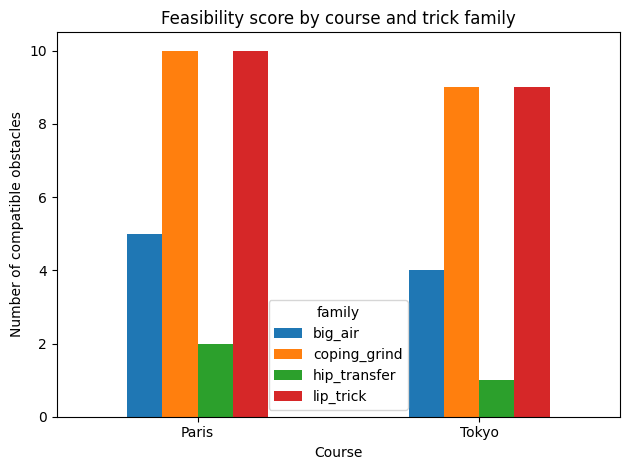

In [10]:
# bar chart that shows feasibility results

plt.figure(figsize=(6,4))
feasibility.plot(kind="bar")
plt.ylabel("Number of compatible obstacles")
plt.xlabel("Course")
plt.title("Feasibility score by course and trick family")
plt.xticks(rotation=0)
plt.tight_layout()

plt.savefig("feasibility_by_course_family.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
# c) T-test

# for each trick family, compares obstacle depth between compatible and not-compatible obstacle–trick pairs
# - loops over each trick family
# - for each family, it splits obstacles into 2 groups: compatible vs. NOT compatible
# - compares their mean depths and runs a t-test to see if compatible obstacles are deeper or shallower than non-compatible ones

for fam in trick_families["family"]:
    df = course_trick_pairs[course_trick_pairs["family"] == fam]
    depth_yes = df.loc[df["compatible"] == 1, "depth_m"]
    depth_no  = df.loc[df["compatible"] == 0, "depth_m"]

    mean_yes = depth_yes.mean()
    mean_no  = depth_no.mean()

    t_stat, p = ttest_ind(depth_yes, depth_no, equal_var=False)

    print(f"\nFamily: {fam}")
    print(f"Compatible:    n={len(depth_yes)}, mean depth={mean_yes:.2f} m")
    print(f"Not compatible: n={len(depth_no)}, mean depth={mean_no:.2f} m")
    print(f"t = {t_stat:.3f}, p = {p:.4f}")


Family: big_air
Compatible:    n=9, mean depth=2.73 m
Not compatible: n=11, mean depth=1.98 m
t = 7.063, p = 0.0000

Family: lip_trick
Compatible:    n=19, mean depth=2.37 m
Not compatible: n=1, mean depth=1.40 m
t = nan, p = nan

Family: coping_grind
Compatible:    n=19, mean depth=2.37 m
Not compatible: n=1, mean depth=1.40 m
t = nan, p = nan

Family: hip_transfer
Compatible:    n=3, mean depth=2.33 m
Not compatible: n=17, mean depth=2.32 m
t = 0.088, p = 0.9326


<Figure size 400x400 with 0 Axes>

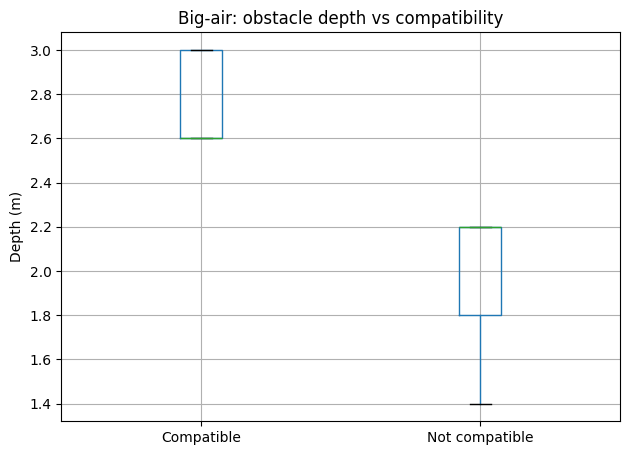

In [12]:
# box-plot that investigates further how obstacle depths are distributed for compatible vs not compatible spots for big air trick family

big = course_trick_pairs[course_trick_pairs["family"] == "big_air"].copy()
big["compat_label"] = big["compatible"].map({1: "Compatible", 0: "Not compatible"})

plt.figure(figsize=(4,4))
big.boxplot(column="depth_m", by="compat_label")
plt.ylabel("Depth (m)")
plt.xlabel("")
plt.title("Big-air: obstacle depth vs compatibility")
plt.suptitle("")
plt.tight_layout()

plt.savefig("bigair_depth_vs_compatibility.png", dpi=300, bbox_inches="tight")
plt.show()

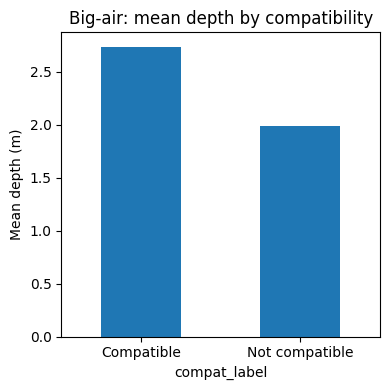

In [13]:
# bar chart that investigates how feasible are big-air tricks on obstacles of varying depth

means = big.groupby("compat_label")["depth_m"].mean()

plt.figure(figsize=(4,4))
means.plot(kind="bar")
plt.ylabel("Mean depth (m)")
plt.title("Big-air: mean depth by compatibility")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
# d) Fisher Test

# for each trick family, builds a Tokyo vs Paris × compatible vs not-compatible 2x2 table
# tests whether the proportions of compatible spots differ by course

for fam in trick_families["family"]:
    sub = course_trick_pairs[course_trick_pairs["family"] == fam]
    
    # 2x2 table: rows = course, cols = compatible (0/1)
    table = pd.crosstab(sub["course_id"], sub["compatible"])
    table = table.reindex(columns=[0, 1], fill_value=0)  # make sure both cols exist
    
    # counts: [ [Tokyo compat, Tokyo not], [Paris compat, Paris not] ]
    tok_compat = table.loc["Tokyo", 1]
    tok_not    = table.loc["Tokyo", 0]
    par_compat = table.loc["Paris", 1]
    par_not    = table.loc["Paris", 0]
    
    oddsratio, p = fisher_exact([[tok_compat, tok_not],
                                 [par_compat, par_not]])
    
    print(f"Family: {fam}")
    print(table)
    print(f"Fisher exact p-value = {p:.4f}\n")

Family: big_air
compatible  0  1
course_id       
Paris       5  5
Tokyo       6  4
Fisher exact p-value = 1.0000

Family: lip_trick
compatible  0   1
course_id        
Paris       0  10
Tokyo       1   9
Fisher exact p-value = 1.0000

Family: coping_grind
compatible  0   1
course_id        
Paris       0  10
Tokyo       1   9
Fisher exact p-value = 1.0000

Family: hip_transfer
compatible  0  1
course_id       
Paris       8  2
Tokyo       9  1
Fisher exact p-value = 1.0000



In [15]:
# e) Logistic Regression

def fit_logit_for_family(family_name):
    
    # filters rows for a trick family
    df = course_trick_pairs[course_trick_pairs["family"] == family_name].copy()
    
    # predictor matrix: depth_m only (simple model)
    X = sm.add_constant(df[["depth_m"]])  # adds intercept column (B0)

    # y: 1 = compatible, 0 = not compatible
    y = df["compatible"]
    
    # fits logistic regression 
    model = sm.Logit(y, X).fit(disp=False)  # disp=False = doesn't print iteration
    
    print(f"\n==============================")
    print(f"Logistic regression for family: {family_name}")
    print("==============================")
    print(model.summary())
    
    # computes odds ratios + 95% confidence intervals
    params = model.params          # B coefficients
    conf = model.conf_int()        # CI in log-odds scale
    odds_ratios = np.exp(params)   # exp(B) = odds ratio
    conf_odds = np.exp(conf)       # CI on odds ratio scale
    
    print("\nOdds ratios (exp(coef)) with 95% CI:")
    for param_name in params.index:
        print(
            f"{param_name:>10}: "
            f"OR = {odds_ratios[param_name]:.3f} "
            f"[{conf_odds.loc[param_name, 0]:.3f}, {conf_odds.loc[param_name, 1]:.3f}]"
        )
    
    return model

In [16]:
# runs the model separately for each trick family
models = {}

for fam in trick_families["family"]:
    models[fam] = fit_logit_for_family(fam)


Logistic regression for family: big_air
                           Logit Regression Results                           
Dep. Variable:             compatible   No. Observations:                   20
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                   1.000
Time:                        23:19:39   Log-Likelihood:            -2.8170e-09
converged:                      False   LL-Null:                       -13.763
Covariance Type:            nonrobust   LLR p-value:                 1.550e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -266.0286   2.26e+05     -0.001      0.999   -4.43e+05    4.43e+05
depth_m      110.8781   9.45e+04      0.001      0.999   -1.85e+05    1.85e+05

Complete S

/Users/ofthekings/anaconda3/envs/myenv/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/ofthekings/anaconda3/envs/myenv/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/ofthekings/anaconda3/envs/myenv/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/ofthekings/anaconda3/envs/myenv/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter ma

## (iii.1) Adding "Synthetic" Data
The original dataset has only 20 obstacles × 4 families = 80 samples, and it has strict rule-based labels that logistic regression fails (perfect separation)... *(you'll see the warning by scrolling on the result from block [14]... it's the big pink block... can't miss it...)*

I am "exploring" here by increasing the dataset size by creating slightly modified copies of each obstacle that is still within range by doing small *jitters* around those ranges (so they are **NOT** arbitrary) so I can (re-)run logistic regression without perfect separation and see how a model might behave if more real-world data were available


#### Jitter Details:
##### Centre of the jitter:
For each obstacle, the random value is centred on the original measurement:
* depth: mean = row["depth_m"]
* radius: mean = row["radius_m"]

I'm not inventing a random depth, but making small variations around the real depth for that obstacle

##### Size of the jitter (spread):
* Depth: 0.15 m
* Radius: 0.10 m

##### Physical bounds (clipping):
Depth is clipped to [1.4, 3.0] m
Radius is clipped to [2.0, 3.0] m

These come from your earlier “realistic bowl” ranges (World Skate docs + skatepark design guides). They make sure the noise never produces non-realistic values (like a 0.5 m “deep bowl”).

I should **reiterate**: this is *exploratory* and does not claim that the model reflects real-world probabilities, but shows how a geometry-based statistical model could operate if richer datasets existed

In [17]:
# Creating a bigger data

np.random.seed(42)  # for reproducibility

def depth_to_level(d):
    
    # same 5-level scale as before
    if d < 1.7:   return 1
    elif d < 2.1: return 2
    elif d < 2.5: return 3
    elif d < 2.9: return 4
    else:         return 5

def radius_to_class(r):
    if r < 2.2:   return 1
    elif r < 2.6: return 2
    else:         return 3

rows = []

# 5 variants of each existing obstacle (10 * 5 = 50 per course)
for _, row in obstacles.iterrows():
    for k in range(5):
        new = row.copy()

        # new obstacle id so they are unique
        new["obstacle_id"] = f"{row['obstacle_id']}_v{k+1}"

        # jitter depth around the original by +/- 0.15 m
        depth = np.random.normal(row["depth_m"], 0.15)
        depth = float(np.clip(depth, 1.4, 3.0))
        new["depth_m"] = depth
        new["depth_level"] = depth_to_level(depth)

        # jitter radius around original by +/- 0.1 m
        radius = np.random.normal(row["radius_m"], 0.10)

        
        radius = float(np.clip(radius, 2.0, 3.0))
        new["radius_m"] = radius
        new["radius_class"] = radius_to_class(radius)

        rows.append(new)

obstacles_synth = pd.DataFrame(rows)

print(obstacles_synth.shape)      # prints obstacle dataset (rows x columns) after generating 5 variations for each obstacle
obstacles_synth.head()

(100, 9)


,course_id,obstacle_id,feature_name,depth_level,depth_m,radius_class,radius_m,has_hip,has_extension
0,Tokyo,T1_v1,Main Deep Bowl,5,3.000000,2,2.586174,0,0
0,Tokyo,T1_v2,Main Deep Bowl,5,3.000000,3,2.752303,0,0
0,Tokyo,T1_v3,Main Deep Bowl,5,2.964877,2,2.576586,0,0
0,Tokyo,T1_v4,Main Deep Bowl,5,3.000000,3,2.676743,0,0
0,Tokyo,T1_v5,Main Deep Bowl,5,2.929579,3,2.654256,0,0


In [18]:
# combining obstacle data with family
# gives a complete (synthetic) dataset of 400 rows!

course_trick_pairs_synth = obstacles_synth.merge(trick_families, how="cross")
course_trick_pairs_synth.shape   # 100 * 4 = 400 rows
course_trick_pairs_synth.head()

,course_id,obstacle_id,feature_name,depth_level,depth_m,radius_class,radius_m,has_hip,has_extension,family,min_depth,max_depth,requires_hip,uses_extension
0,Tokyo,T1_v1,Main Deep Bowl,5,3.0,2,2.586174,0,0,big_air,2.5,3.4,0,1
1,Tokyo,T1_v1,Main Deep Bowl,5,3.0,2,2.586174,0,0,lip_trick,1.6,3.0,0,0
2,Tokyo,T1_v1,Main Deep Bowl,5,3.0,2,2.586174,0,0,coping_grind,1.8,3.2,0,0
3,Tokyo,T1_v1,Main Deep Bowl,5,3.0,2,2.586174,0,0,hip_transfer,2.0,3.0,1,0
4,Tokyo,T1_v2,Main Deep Bowl,5,3.0,3,2.752303,0,0,big_air,2.5,3.4,0,1


### (iii.2) Logistic Model
Defined a simple logistic function for each trick family, with hand-chosen coefficients that assigns each obstacle–family pair a probability of being compatible, and a Bernoulli draw (biased coin flip) converts that probability into a binary compatibility label

**For each obstacle–trick-family pair in course_trick_pairs_synth:**

#### a) Computes linear score z from geometry:
$$
z = \alpha \;+\; \beta_{\text{depth}}\cdot \text{depth\_m} \;+\; \beta_{\text{hip}}\cdot \text{has\_hip} \;+\; \beta_{\text{ext}}\cdot \text{has\_extension}
$$

where the variables come from the family_params dictionary

#### b) Converts score to probability with logistic function:
$$
P = \frac{1}{1 + e^{-z}}
$$

* if z is positive: p close to 1 (very likely compatible).
* if z is negative: p close to 0 (very unlikely compatible).

#### c) Uses probability to generate 0/1 model:
flips a biased coin with success probability P(compatible). If it lands ‘success’, set compatible = 1, if not then compatible = 0.

Compared to my initial model, here, I don’t first decide “compatible yes/no” and then feed that into logistic. Instead, it's the logistic function that creates the probability, and then I sample the yes/no label from that probability.

In [19]:
# Logistic Model

# converts a number into a probability:
# if z is +: probability close to 1
# if z is -: probability close to 0
def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

# hand-chosen parameters for each family
family_params = {
    "big_air": {
        "alpha":   -7.0,
        "beta_depth":  2.8,
        "beta_hip":    0.0,
        "beta_ext":    1.2,
    },
    "lip_trick": {
        "alpha":   -3.0,
        "beta_depth":  1.5,
        "beta_hip":    0.0,
        "beta_ext":    0.0,
    },
    "coping_grind": {
        "alpha":   -3.5,
        "beta_depth":  1.8,
        "beta_hip":    0.0,
        "beta_ext":    0.0,
    },
    "hip_transfer": {
        "alpha":   -5.0,
        "beta_depth":  2.0,
        "beta_hip":    1.5,
        "beta_ext":    0.0,
    },
}

# computes a score that is then passed through the logistic f-n
# yields a p = probability that obstacle is compatible with family
def compute_prob(row):
    p = family_params[row["family"]]
    z = (
        p["alpha"]
        + p["beta_depth"] * row["depth_m"]
        + p["beta_hip"] * row["has_hip"]
        + p["beta_ext"] * row["has_extension"]
    )
    return logistic(z)

# probability of being compatible
course_trick_pairs_synth["p_compatible"] = course_trick_pairs_synth.apply(
    compute_prob, axis=1
)

# sample a binary outcome from that probability
np.random.seed(123)
course_trick_pairs_synth["compatible"] = np.random.binomial(
    1, course_trick_pairs_synth["p_compatible"]
)

course_trick_pairs_synth[["course_id", "family", "depth_m", "p_compatible", "compatible"]].head(10)

,course_id,family,depth_m,p_compatible,compatible
0,Tokyo,big_air,3.000000,0.802184,1
1,Tokyo,lip_trick,3.000000,0.817574,1
2,Tokyo,coping_grind,3.000000,0.869892,1
3,Tokyo,hip_transfer,3.000000,0.731059,1
4,Tokyo,big_air,3.000000,0.802184,1
5,Tokyo,lip_trick,3.000000,0.817574,1
6,Tokyo,coping_grind,3.000000,0.869892,0
7,Tokyo,hip_transfer,3.000000,0.731059,1
8,Tokyo,big_air,2.964877,0.786113,1
9,Tokyo,lip_trick,2.964877,0.809585,1


### (iii.3) Logistic Regression (again...) 

$$
\log\!\left(\frac{P(\text{compat}=1)}{P(\text{compat}=0)}\right)
= \beta_0 + \beta_1\,\text{depth\_m}
  + \beta_2\,\text{has\_hip}
  + \beta_3\,\text{has\_extension}.
$$

In [20]:
# Logistic Regression

def fit_logit_synth(family_name):

    # filters synthetic rows for a trick family
    df = course_trick_pairs_synth[course_trick_pairs_synth["family"] == family_name].copy()

    # creating matrix
    X = df[["depth_m", "has_hip", "has_extension"]]
    X = sm.add_constant(X)      # adds intercept column
    y = df["compatible"]        # 0/1 label from logistic f-n

    # fits logistic regression
    model = sm.Logit(y, X).fit(disp=False)
    
    print(f"\n==============================")
    print(f"SYNTHETIC logistic regression for family: {family_name}")
    print("==============================")
    print(model.summary())
    
    # odds ratios
    params = model.params
    conf = model.conf_int()
    odds = np.exp(params)
    conf_odds = np.exp(conf)
    
    print("\nOdds ratios (exp(coef)) with 95% CI:")
    for name in params.index:
        print(
            f"{name:>10}: OR = {odds[name]:.2f} "
            f"[{conf_odds.loc[name,0]:.2f}, {conf_odds.loc[name,1]:.2f}]"
        )
    
    return model

models_synth = {}
for fam in trick_families["family"]:
    models_synth[fam] = fit_logit_synth(fam)


SYNTHETIC logistic regression for family: big_air
                           Logit Regression Results                           
Dep. Variable:             compatible   No. Observations:                  100
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            3
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                  0.4843
Time:                        23:19:40   Log-Likelihood:                -35.702
converged:                       True   LL-Null:                       -69.235
Covariance Type:            nonrobust   LLR p-value:                 1.813e-14
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -10.9116      2.363     -4.617      0.000     -15.543      -6.280
depth_m           4.4480      0.987      4.504      0.000       2.513  